In [4]:
import os
import random
import shutil

def count_images(folder):
    return len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])

def oversample(folder, target_count):
    image_files = os.listdir(folder)
    current_count = len(image_files)
    oversample_count = target_count - current_count

    while oversample_count > 0:
        random_file = random.choice(image_files)
        source = os.path.join(folder, random_file)
        new_file = os.path.splitext(random_file)[0] + f'_oversampled_{oversample_count}' + os.path.splitext(random_file)[1]
        destination = os.path.join(folder, new_file)
        shutil.copy(source, destination)
        oversample_count -= 1

def undersample(folder, target_count):
   
    image_files = os.listdir(folder)
    current_count = len(image_files)

    if current_count > target_count:
        files_to_remove = random.sample(image_files, current_count - target_count)
        for file in files_to_remove:
            os.remove(os.path.join(folder, file))

def move_images(source_folder, destination_folder, count):
   
    images = random.sample(os.listdir(source_folder), count)
    for image in images:
        source = os.path.join(source_folder, image)
        destination = os.path.join(destination_folder, image)
        shutil.move(source, destination)

def preprocess_dataset(training_dir, test_dir, output_dir, oversample_target=1405, undersample_target=1300):
   
    combined_dir = os.path.join(output_dir, 'combined')
    os.makedirs(combined_dir, exist_ok=True)

   
    for folder in [training_dir, test_dir]:
        class_folders = os.listdir(folder)
        for class_folder in class_folders:
            src = os.path.join(folder, class_folder)
            dst = os.path.join(combined_dir, class_folder)
            shutil.copytree(src, dst, dirs_exist_ok=True)

    for class_folder in os.listdir(combined_dir):
        class_folder_path = os.path.join(combined_dir, class_folder)
        current_count = count_images(class_folder_path)

        if current_count < undersample_target:
            oversample(class_folder_path, oversample_target)
        elif current_count > oversample_target:
            undersample(class_folder_path, oversample_target)

   
    train_ratio = 8
    validation_ratio = 1
    test_ratio = 1

    train_folder = os.path.join(output_dir, 'train')
    validation_folder = os.path.join(output_dir, 'validation')
    test_folder = os.path.join(output_dir, 'test')

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(validation_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    for class_folder in os.listdir(combined_dir):
        class_folder_path = os.path.join(combined_dir, class_folder)
        total_images = count_images(class_folder_path)

        train_count = int(total_images * train_ratio / (train_ratio + validation_ratio + test_ratio))
        validation_count = int(total_images * validation_ratio / (train_ratio + validation_ratio + test_ratio))
        test_count = total_images - train_count - validation_count

        train_class_folder = os.path.join(train_folder, class_folder)
        validation_class_folder = os.path.join(validation_folder, class_folder)
        test_class_folder = os.path.join(test_folder, class_folder)

        os.makedirs(train_class_folder, exist_ok=True)
        os.makedirs(validation_class_folder, exist_ok=True)
        os.makedirs(test_class_folder, exist_ok=True)

        move_images(class_folder_path, train_class_folder, train_count)
        move_images(class_folder_path, validation_class_folder, validation_count)
        move_images(class_folder_path, test_class_folder, test_count)

  
    shutil.rmtree(combined_dir)


training_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'
output_dir = '/kaggle/working/dataset'

preprocess_dataset(training_dir, test_dir, output_dir)

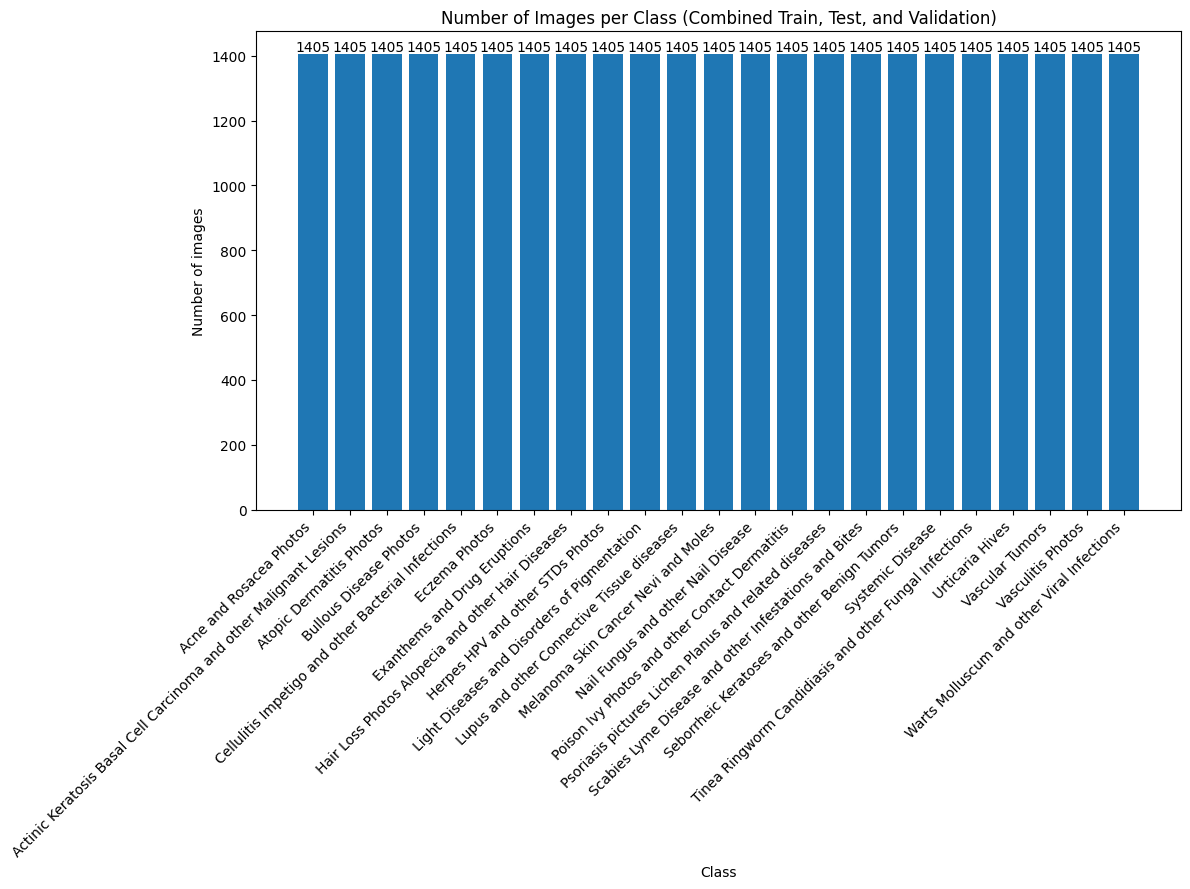

In [5]:

import matplotlib.pyplot as plt
dataset_dir = 'dataset'


train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
validation_dir = os.path.join(dataset_dir, 'validation')

class_names = sorted(os.listdir(train_dir))

train_data_counts = []
test_data_counts = []
validation_data_counts = []


for class_name in class_names:
    
    train_class_dir = os.path.join(train_dir, class_name)
    train_data_count = len(os.listdir(train_class_dir))
    train_data_counts.append(train_data_count)

    test_class_dir = os.path.join(test_dir, class_name)
    test_data_count = len(os.listdir(test_class_dir))
    test_data_counts.append(test_data_count)

    validation_class_dir = os.path.join(validation_dir, class_name)
    validation_data_count = len(os.listdir(validation_class_dir))
    validation_data_counts.append(validation_data_count)


combined_data_counts = [train_count + test_count + validation_count for train_count, test_count, validation_count in zip(train_data_counts, test_data_counts, validation_data_counts)]


plt.figure(figsize=(12, 9))
plt.bar(class_names, combined_data_counts)
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Number of Images per Class (Combined Train, Test, and Validation)')
plt.xticks(rotation=45, ha='right')


for i, count in enumerate(combined_data_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')


plt.tight_layout()
plt.show()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_path = 'dataset'

train_folder = os.path.join(dataset_path, 'train')
validation_folder = os.path.join(dataset_path, 'validation')
test_folder = os.path.join(dataset_path, 'test')

def train_val_generators():

    train_datagen = ImageDataGenerator(
            rotation_range=30,
            brightness_range=[0.9, 1.3],
            zoom_range=0.3,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest',
            rescale=1./255
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

  
    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical'
    )

    validation_generator = validation_datagen.flow_from_directory(
        validation_folder,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical'
    )

    return train_generator, validation_generator

train_generator, validation_generator = train_val_generators()

Found 25852 images belonging to 23 classes.
Found 3220 images belonging to 23 classes.


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [9]:

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(23, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:

for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-9)

history = model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[early_stopping, reduce_lr])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


404/404 ━━━━━━━━━━━━━━━━━━━━ 677s 1s/step - accuracy: 0.1299 - loss: 3.8027 - val_accuracy: 0.3640 - val_loss: 2.6254 - learning_rate: 1.0000e-04
Epoch 2/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 394s 957ms/step - accuracy: 0.3394 - loss: 2.6567 - val_accuracy: 0.5842 - val_loss: 1.9752 - learning_rate: 1.0000e-04
Epoch 3/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 394s 957ms/step - accuracy: 0.5048 - loss: 2.0829 - val_accuracy: 0.6919 - val_loss: 1.5693 - learning_rate: 1.0000e-04
Epoch 4/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 394s 959ms/step - accuracy: 0.6212 - loss: 1.7063 - val_accuracy: 0.7581 - val_loss: 1.3343 - learning_rate: 1.0000e-04
Epoch 5/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 393s 956ms/step - accuracy: 0.7147 - loss: 1.3993 - val_accuracy: 0.8214 - val_loss: 1.0551 - learning_rate: 1.0000e-04
Epoch 6/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 393s 956ms/step - accuracy: 0.7897 - loss: 1.1485 - val_accuracy: 0.8686 - val_loss: 0.8719 - learning_rate: 1.0000e-04
Epoch 7/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 396s 962ms/ste

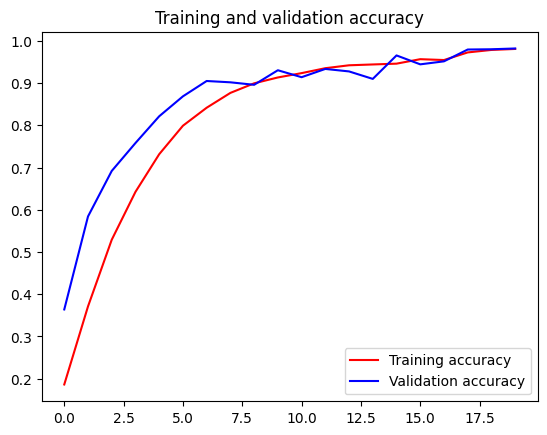

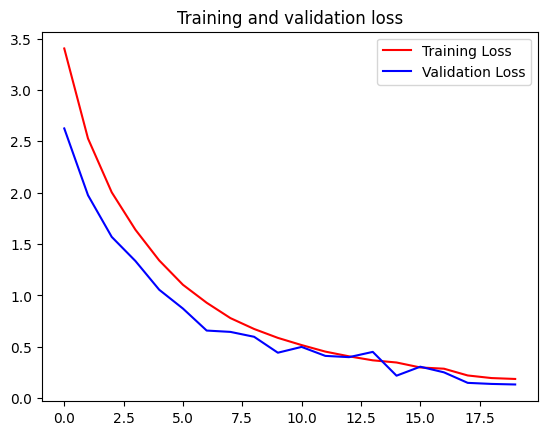

In [11]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:

test_folder = 'dataset/test'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical',
        shuffle=False
    )

Found 3243 images belonging to 23 classes.


In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)


true_labels = test_generator.classes


print(classification_report(true_labels, predicted_labels))

print(confusion_matrix(true_labels, predicted_labels))

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


203/203 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       141
           1       0.96      0.95      0.95       141
           2       0.98      0.99      0.99       141
           3       0.99      1.00      1.00       141
           4       1.00      1.00      1.00       141
           5       0.89      0.99      0.94       141
           6       0.99      0.99      0.99       141
           7       0.98      1.00      0.99       141
           8       0.98      0.99      0.98       141
           9       0.97      0.96      0.96       141
          10       1.00      1.00      1.00       141
          11       1.00      0.99      1.00       141
          12       0.99      0.93      0.96       141
          13       0.96      1.00      0.98       141
          14       0.94      0.92      0.93       141
          15       0.99      1.00      1.00       141
          16       0.97      0.94    

In [14]:
model.save('/kaggle/working/client.h5')